<a href="https://colab.research.google.com/github/gkv856/KaggleData/blob/main/AutoVC_training_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/gkv856/end2end_auto_voice_conversion.git

Cloning into 'end2end_auto_voice_conversion'...
remote: Enumerating objects: 720, done.
remote: Counting objects: 100% (720/720), done.
remote: Compressing objects: 100% (521/521), done.
remote: Total 720 (delta 257), reused 616 (delta 153), pack-reused 0
Receiving objects: 100% (720/720), 266.45 MiB | 31.29 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (213/213), done.


In [2]:
!mv end2end_auto_voice_conversion/ AVC/

In [3]:
pip install webrtcvad

     |████████████████████████████████| 66 kB 2.8 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72381 sha256=d85a7b82aeb1d30339feabc54147db687457fadaf29ff9f172277b7d7f152858
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
Successfully built webrtcvad


In [4]:
from AVC.strings.constants import hp

Device type available = 'cuda:0'


Pre-trained model loaded /content/AVC/static/model_chk_pts/ge2e/embedding_model_GE2E_loss_epoch_1000_L_0.0003.pth
File saved!!


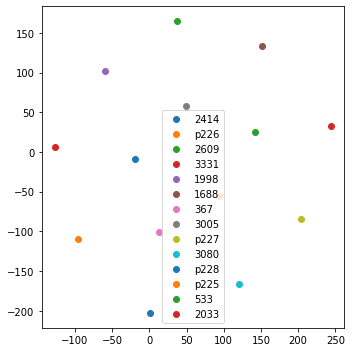

In [5]:
import torch

from AVC.s3_auto_voice_cloner.s1_create_emb_per_speaker import create_embbedings_per_speaker

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# hp.m_ge2e.best_model_path = "static/model_chk_pts/ge2e/final_epoch_1000_L_0.0390.pth"

utterances = create_embbedings_per_speaker(hp)


labels = []
embs = []
for k, v in utterances.items():
    embs.append(v)
    labels.append(k)


embeddings = torch.tensor(embs)

scatters = TSNE(n_components=2, random_state=0).fit_transform(embeddings.cpu().detach().numpy())
fig = plt.figure(figsize=(5, 5))

current_Label = labels[0]
current_Index = 0
for index, label in enumerate(labels[1:], 1):
    if label != current_Label:
        plt.scatter(scatters[current_Index:index, 0], scatters[current_Index:index, 1],
                    label='{}'.format(current_Label))
        current_Label = label
        current_Index = index

plt.scatter(scatters[current_Index:, 0], scatters[current_Index:, 1], label='{}'.format(current_Label))
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
from AVC.s3_auto_voice_cloner.s5_auto_vc_train import TrainAutoVCNetwork

In [ ]:

hp.m_avc.tpm.lambda_cd = 1
hp.m_avc.tpm.num_iters = 1000
hp.m_avc.tpm.log_step = 100
hp.m_avc.tpm.dot_print = 10
hp.m_avc.tpm.checkpoint_interval = 200
hp.m_avc.tpm.lr = 0.001
hp.m_avc.tpm.reduce_lr_interval = 100
hp.m_avc.tpm.data_batch_size = 2

solver = TrainAutoVCNetwork(hp)
solver.optimizer = torch.optim.Adam(solver.auto_vc_net.parameters(), 
                                    lr=solver.lr,
                                    betas=(0.9, 0.999),
                                    eps=1e-7,
                                    weight_decay=0)
# start the training
auto_vc_model, lst_loss_tuple = solver.start_training()


Started Batched Training...
Epoch:[100/1000] ..

In [ ]:
hp.m_avc.gen.best_model_path = "/content/AVC/static/model_chk_pts/autovc/final_1000.pth"

In [ ]:
!pip install wavenet_vocoder
!pip install webrtcvad

In [ ]:
import torch

from AVC.s3_auto_voice_cloner.s1_create_emb_per_speaker import create_embbedings_per_speaker

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# hp.m_ge2e.best_model_path = "static/model_chk_pts/ge2e/final_epoch_1000_L_0.0390.pth"

utterances = create_embbedings_per_speaker(hp)


labels = []
embs = []
for k, v in utterances.items():
    embs.append(v)
    labels.append(k)


embeddings = torch.tensor(embs)

scatters = TSNE(n_components=2, random_state=0).fit_transform(embeddings.cpu().detach().numpy())
fig = plt.figure(figsize=(5, 5))

current_Label = labels[0]
current_Index = 0
for index, label in enumerate(labels[1:], 1):
    if label != current_Label:
        plt.scatter(scatters[current_Index:index, 0], scatters[current_Index:index, 1],
                    label='{}'.format(current_Label))
        current_Label = label
        current_Index = index

plt.scatter(scatters[current_Index:, 0], scatters[current_Index:, 1], label='{}'.format(current_Label))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import tqdm

from AVC.s3_auto_voice_cloner.s6_create_cross_speaker_mel_specs import VoiceCloner
import soundfile as sf
import os

In [ ]:
hp.m_avc.gen.best_model_path = "/content/AVC/static/model_chk_pts/autovc/final_1000.pth"
hp.m_wave_net.gen.best_model_path = "/content/drive/MyDrive/AI_ML_DL/model_chk_pts/wavenet_model/wavenet_pretrained_step001000000_ema.pth"
vcs_obj = VoiceCloner(hp, tqdm, absolute_path=True)

path_audio = "static/raw_data/wavs/p225/p225_003.wav"
path_audio = os.path.join(hp.general.project_root, path_audio)
spkr_p225_mel_spec = vcs_obj.au.get_mel_spects_from_audio(path_audio, partial_slices=False)

path_audio = "static/raw_data/wavs/p226/p226_003.wav"
path_audio = os.path.join(hp.general.project_root, path_audio)
spkr_p226_mel_spec = vcs_obj.au.get_mel_spects_from_audio(path_audio, partial_slices=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import librosa
import librosa.display

In [ ]:
# Plot mel spectrograms
fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].set(title = 'Mel Spectrogram of Guitar')
i = librosa.display.specshow(spkr_p225_mel_spec, ax=ax[0])

ax[1].set(title = 'Mel Spectrogram of Kick')
librosa.display.specshow(spkr_p226_mel_spec, ax=ax[1])

plt.colorbar(i)

In [ ]:
avc_mel_specs = vcs_obj.create_cross_spkr_mel_spects("p225", "p226", spkr_p225_mel_spec[:320, :])
avc_mel_specs.shape

In [ ]:
# Plot mel spectrograms
fig, ax = plt.subplots(1,2, figsize = (20,10))

ax[0].set(title = 'Mel Spectrogram of P225')
i = librosa.display.specshow(spkr_p225_mel_spec[:320, :], ax=ax[0])

ax[1].set(title = 'AVC mel spect')
librosa.display.specshow(avc_mel_specs, ax=ax[1])

plt.colorbar(i)